In [1]:
import pandas as pd
import numpy as np
from datasets import Dataset
from sklearn.preprocessing import LabelEncoder
import transformers
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification, Trainer, TrainingArguments
import torch
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns 

In [2]:
input_labelled = pd.read_csv('C:/Users/Dinesh/Git_Hub/HostelFix-AI/data/data_input.csv')
input0 = pd.DataFrame(input_labelled)
df = input0
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1382 entries, 0 to 1381
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   complaint      1382 non-null   object
 1   priority       1382 non-null   int64 
 2   parts          1382 non-null   object
 3   repair_person  1382 non-null   object
dtypes: int64(1), object(3)
memory usage: 43.3+ KB


In [3]:
target_col = 'priority'

In [4]:
le = LabelEncoder()
df['label'] = le.fit_transform(df[target_col])
num_labels = len(le.classes_)

In [5]:
from sklearn.model_selection import train_test_split
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df['complaint'].tolist(), df['label'].tolist(), 
    test_size=0.2, stratify=df['label'], random_state=42
)

In [6]:
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=128)
test_encodings = tokenizer(test_texts, truncation=True, padding=True, max_length=128)


In [7]:
train_dataset = Dataset.from_dict({**train_encodings, 'label': train_labels})
test_dataset = Dataset.from_dict({**test_encodings, 'label': test_labels})


In [8]:
model = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased", num_labels=num_labels
)


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [9]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)
    acc = accuracy_score(labels, preds)
    p, r, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    return {
        'accuracy': acc,
        'precision': p,
        'recall': r,
        'f1': f1
    }

In [10]:
# 5. Define training arguments
training_args = TrainingArguments(
    output_dir="./distilbert-hostel-priority",  # directory to save the model
    eval_strategy="epoch",                # evaluate at the end of each epoch
    learning_rate=2e-5,
    per_device_train_batch_size=16,             # adjust based on your GPU or CPU availability
    per_device_eval_batch_size=16,
    num_train_epochs=5,                         # you might want to increase/decrease this
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    save_strategy="epoch",
)

In [12]:
import pandas as pd
from sklearn.model_selection import train_test_split
from datasets import Dataset

import evaluate

metric = evaluate.load("accuracy")


import numpy as np
import torch

from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification
from transformers import Trainer, TrainingArguments, DataCollatorWithPadding

In [13]:
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['priority'])

In [14]:
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)

# 3. Load the DistilBERT tokenizer
tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")

# Define a tokenization function
def tokenize_function(example):
    return tokenizer(example["complaint"], truncation=True)

In [15]:
train_dataset = train_dataset.map(tokenize_function, batched=True)
val_dataset = val_dataset.map(tokenize_function, batched=True)

# Remove columns that we don't need (like the raw text)
train_dataset = train_dataset.remove_columns(["complaint", "__index_level_0__"]) if "__index_level_0__" in train_dataset.column_names else train_dataset.remove_columns(["complaint"])
val_dataset = val_dataset.remove_columns(["complaint", "__index_level_0__"]) if "__index_level_0__" in val_dataset.column_names else val_dataset.remove_columns(["complaint"])

Map:   0%|          | 0/1105 [00:00<?, ? examples/s]

Map:   0%|          | 0/277 [00:00<?, ? examples/s]

In [16]:
# Set the format of the datasets to PyTorch tensors
train_dataset.set_format("torch")
val_dataset.set_format("torch")

# Determine the number of labels. For example, if there are 3 priority levels:
num_labels = len(df['priority'].unique())
if df['priority'].min() == 1:
    num_labels += 1

# 4. Load the DistilBERT pre-trained model for sequence classification
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=num_labels)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [18]:
# 5. Define training arguments
training_args = TrainingArguments(
    output_dir="./distilbert-hostel-priority",  # directory to save the model
    eval_strategy="epoch",                # evaluate at the end of each epoch
    learning_rate=2e-5,
    per_device_train_batch_size=16,             # adjust based on your GPU or CPU availability
    per_device_eval_batch_size=16,
    num_train_epochs=5,                         # you might want to increase/decrease this
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    save_strategy="epoch",
)

In [19]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

C:\Users\Dinesh\AppData\Local\Temp\ipykernel_19072\2388959174.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [20]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,1.264400,1.246587,0.530686,0.639639,0.530686,0.466508
2,1.019600,0.992113,0.606498,0.586787,0.606498,0.584141
3,0.699700,0.939615,0.613718,0.606920,0.613718,0.571588
4,0.624300,0.870588,0.631769,0.623955,0.631769,0.623645
5,0.659900,0.849809,0.649819,0.636313,0.649819,0.638140


TrainOutput(global_step=350, training_loss=0.9712862941196987, metrics={'train_runtime': 295.5152, 'train_samples_per_second': 18.696, 'train_steps_per_second': 1.184, 'total_flos': 29413223954388.0, 'train_loss': 0.9712862941196987, 'epoch': 5.0})

In [21]:
eval_result = trainer.evaluate()
print("📊 Final Evaluation:", eval_result)

📊 Final Evaluation: {'eval_loss': 0.8498092889785767, 'eval_accuracy': 0.6498194945848376, 'eval_precision': 0.6363134564076863, 'eval_recall': 0.6498194945848376, 'eval_f1': 0.6381403555746654, 'eval_runtime': 4.7387, 'eval_samples_per_second': 58.455, 'eval_steps_per_second': 3.799, 'epoch': 5.0}


In [24]:
# ==== Preprocessing for Priority Prediction ====
target_col = 'priority'
df = df[df[target_col].notnull()]  # Drop NaNs if any

# Assuming priority values are from 1 to 5 → convert to 0 to 4 for training
df['label'] = df[target_col] - 1
num_labels = df['label'].nunique()

# ==== Train-Test Split ====
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df['complaint'].tolist(),
    df['label'].tolist(),
    test_size=0.2,
    stratify=df['label'],
    random_state=42
)

# ==== Tokenization ====
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=128)
test_encodings = tokenizer(test_texts, truncation=True, padding=True, max_length=128)

# ==== Convert to HuggingFace Datasets ====
train_dataset = Dataset.from_dict({**train_encodings, 'label': train_labels})
test_dataset = Dataset.from_dict({**test_encodings, 'label': test_labels})

# ==== Load Pretrained Model ====
model = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=num_labels
)

# ==== Define Metrics ====
def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)
    acc = accuracy_score(labels, preds)
    p, r, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    return {
        'accuracy': acc,
        'precision': p,
        'recall': r,
        'f1': f1
    }

# ==== Training Arguments ====
training_args = TrainingArguments(
    output_dir='./priority_model',
    eval_strategy="epoch",
    save_strategy="epoch",
    num_train_epochs=10,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    learning_rate=2e-5,
    weight_decay=0.01,
    logging_dir='./logs',
    load_best_model_at_end=True,
    metric_for_best_model='f1',
    save_total_limit=2
)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [26]:
from transformers import EarlyStoppingCallback

In [28]:
# ==== Add Early Stopping Callback ====
early_stop_callback = EarlyStoppingCallback(early_stopping_patience=2)

# ==== Trainer Setup ====
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[early_stop_callback]
)


C:\Users\Dinesh\AppData\Local\Temp\ipykernel_19072\2043399310.py:5: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [29]:
trainer.train()

# ==== Evaluate ====
results = trainer.evaluate()
print("📊 Final Evaluation on Test Set:", results)

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,1.168388,0.563177,0.554233,0.563177,0.508003
2,No log,0.938317,0.631769,0.617104,0.631769,0.607171
3,No log,0.819936,0.678700,0.677116,0.678700,0.666413
4,No log,0.772063,0.682310,0.694920,0.682310,0.682377
5,No log,0.755525,0.718412,0.721890,0.718412,0.716501
6,No log,0.772610,0.729242,0.730504,0.729242,0.729375
7,No log,0.792177,0.729242,0.729378,0.729242,0.728782
8,0.667600,0.812514,0.743682,0.745918,0.743682,0.743350
9,0.667600,0.837147,0.732852,0.733092,0.732852,0.732411
10,0.667600,0.843497,0.729242,0.729044,0.729242,0.729045


📊 Final Evaluation on Test Set: {'eval_loss': 0.8125140070915222, 'eval_accuracy': 0.7436823104693141, 'eval_precision': 0.7459176427953012, 'eval_recall': 0.7436823104693141, 'eval_f1': 0.7433497021800272, 'eval_runtime': 4.6223, 'eval_samples_per_second': 59.927, 'eval_steps_per_second': 3.894, 'epoch': 10.0}


C:\Users\Dinesh\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


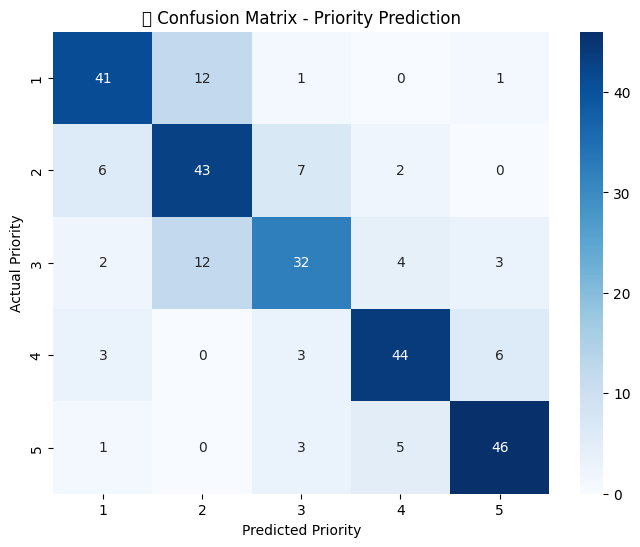


📝 Classification Report:
              precision    recall  f1-score   support

           1       0.77      0.75      0.76        55
           2       0.64      0.74      0.69        58
           3       0.70      0.60      0.65        53
           4       0.80      0.79      0.79        56
           5       0.82      0.84      0.83        55

    accuracy                           0.74       277
   macro avg       0.75      0.74      0.74       277
weighted avg       0.75      0.74      0.74       277



In [34]:
from sklearn.metrics import confusion_matrix, classification_report

# ==== Get predictions on the test set ====
predictions = trainer.predict(test_dataset)
y_true = predictions.label_ids
y_pred = np.argmax(predictions.predictions, axis=1)

# ==== Confusion Matrix ====
cm = confusion_matrix(y_true, y_pred)
class_names = [str(i+1) for i in range(num_labels)]  # Convert 0→"1", 1→"2", etc.

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Priority')
plt.ylabel('Actual Priority')
plt.title(' Confusion Matrix - Priority Prediction')
plt.show()

# ==== Optional: Print Classification Report ====
print("\n📝 Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

In [36]:
def predict_priority(text, model, tokenizer, label_shift=1):
    model.eval()
    
    # Tokenize input
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128)
    
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        predicted_class = torch.argmax(logits, dim=1).item()
    
    # Convert back to 1-5 scale (if you subtracted 1 earlier)
    predicted_priority = predicted_class + label_shift
    return predicted_priority


In [46]:
custom_complaint = ""
predicted = predict_priority(custom_complaint, model, tokenizer)
print(f"Predicted Priority: {predicted}")

Predicted Priority: 5
